**1. Load Libraries and Set Paths**

In [1]:
import os
import nltk
import warnings
import requests

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import defaultdict
from nltk.stem.snowball import SnowballStemmer

from tqdm.notebook import tqdm

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
FOLDER_PATH = '/content/drive/MyDrive/final_project/data'

TRAIN_DATA_PATH = os.path.join(FOLDER_PATH, 'proppy_1.0.train.tsv')
DEV_DATA_PATH = os.path.join(FOLDER_PATH, 'proppy_1.0.dev.tsv')
TEST_DATA_PATH = os.path.join(FOLDER_PATH, 'proppy_1.0.test.tsv')

DATA_COLUMN_LIST = ['text', 'location', 'tone', 'date', 'ID', 'URL',
                    'MBFC_factuality_label', 'URL.1',  'MBFC_factuality_label.1',
                    'URL_to_MBFC_page', 'source_name', 'MBFC_notes_about_source', 
                    'MBFC_bias_label', 'source_URL', 'propaganda_label']

REQUIRED_COLUMN_LIST = ['text', 'propaganda_label']

STOPWORD_LIST_PATH = (
    "https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt"
)

**2. Load Data**

In [3]:
## training data
train_df = pd.read_csv(TRAIN_DATA_PATH, sep='\t', names = DATA_COLUMN_LIST)
print(f"train data shape : {train_df.shape}")
train_df.sample(2)

train data shape : (35986, 15)


,text,location,tone,date,ID,URL,MBFC_factuality_label,URL.1,MBFC_factuality_label.1,URL_to_MBFC_page,source_name,MBFC_notes_about_source,MBFC_bias_label,source_URL,propaganda_label
13794,Malaysian PM sparks storm of criticism over co...,"Kuala Lumpur, Kuala Lumpur, Malaysia",-7.664234,2018-02-25,733737640,https://www.thenews.com.pk/print/285245-malays...,unknown,Malaysian PM sparks storm of criticism over co...,HIGH,https://mediabiasfactcheck.com/the-news-intern...,The News International,The News International,leastbiased02,thenews.com.pk,-1
32957,"In April, I chronicled part of the story of ho...","New York, United States",-4.990758,2018-06-10,763051153,https://www.frontpagemag.com/point/270407/geor...,NaN,"George Soros Comes Out for Groper, Against #MeToo",unknown,unknown,frontpagemag.com,unknown,unknown,frontpagemag.com,1


In [4]:
## validation data
valid_df = pd.read_csv(DEV_DATA_PATH  , sep='\t', names = DATA_COLUMN_LIST)
print(f"validation data shape : {valid_df.shape}")
valid_df.sample(2)

validation data shape : (5125, 15)


,text,location,tone,date,ID,URL,MBFC_factuality_label,URL.1,MBFC_factuality_label.1,URL_to_MBFC_page,source_name,MBFC_notes_about_source,MBFC_bias_label,source_URL,propaganda_label
1946,Denmark to double penalty for crimes in troubl...,Denmark,-7.943925,2018-02-27,734213968,https://www.thenews.com.pk/print/285951-denmar...,unknown,Denmark to double penalty for crimes in troubl...,HIGH,https://mediabiasfactcheck.com/the-news-intern...,The News International,The News International,leastbiased02,thenews.com.pk,-1
2516,An opposition alliance led by Malaysia's forme...,Malaysia,-3.603604,2018-05-09,754527716,https://www.aljazeera.com/news/2018/05/malaysi...,NaN,Malaysia's opposition pulls off shocking elect...,unknown,unknown,aljazeera.com,unknown,unknown,aljazeera.com,-1


In [5]:
## test data
test_df = pd.read_csv(TEST_DATA_PATH  , sep='\t', names = DATA_COLUMN_LIST)
print(f"validation data shape : {test_df.shape}")
test_df.sample(2)

validation data shape : (10159, 15)


,text,location,tone,date,ID,URL,MBFC_factuality_label,URL.1,MBFC_factuality_label.1,URL_to_MBFC_page,source_name,MBFC_notes_about_source,MBFC_bias_label,source_URL,propaganda_label
8513,"BEIRUT, LEBANON (3:00 A.M.) – The Iraqi securi...",Iraq,-5.487805,2018-05-15,756202045,https://www.almasdarnews.com/article/iraqi-for...,The International News Desk Reports On Issues,Iraqi forces foil ISIS attack in southern Mosul,unknown,unknown,almasdarnews.com,unknown,unknown,almasdarnews.com,-1
7049,WASHINGTON (Sputnik) - The United States can n...,"Jerusalem, Israel (general), Israel",-3.397341,2018-05-17,756679973,https://sputniknews.com/analysis/2018051710645...,NaN,Jerusalem Embassy Fiasco May Mark End of US Ro...,unknown,unknown,sputniknews.com,unknown,unknown,sputniknews.com,-1


**3. Basic Analysis**

In [6]:
## the features we are going to work further is mentioned below
train_df = train_df[REQUIRED_COLUMN_LIST]
print(f"train shape : {train_df.shape}")

valid_df = valid_df[REQUIRED_COLUMN_LIST]
print(f"valid shape : {valid_df.shape}")

test_df = test_df[REQUIRED_COLUMN_LIST]
print(f"test shape : {test_df.shape}")

train shape : (35986, 2)
valid shape : (5125, 2)
test shape : (10159, 2)


In [7]:
## get feature information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35986 entries, 0 to 35985
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   text              35986 non-null  object
 1   propaganda_label  35986 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 562.4+ KB


**4. Data Cleaning**

In [8]:
## check for null values
## if present remove from the dataset
print(f"In training data :")
print(train_df.isnull().sum())

print(f"In validation data :")
print(valid_df.isnull().sum())

In training data :
text                0
propaganda_label    0
dtype: int64
In validation data :
text                0
propaganda_label    0
dtype: int64


In [9]:
## check for duplicate rows
print(f"In training data : {train_df[train_df.duplicated()].shape}")
print(f"In validation data : {valid_df[valid_df.duplicated()].shape}")

In training data : (0, 2)
In validation data : (0, 2)


**5. Output Data Analysis**

In [10]:
def pie_plot(data, title):
    """This function plots pie plot for a given data.
    """
    data.plot(kind = 'pie',
          autopct = '%.2f%%',
          colors = ['skyblue', 'teal'],
          figsize=(5,5),
          startangle = 90,
          title = title)
    plt.show()

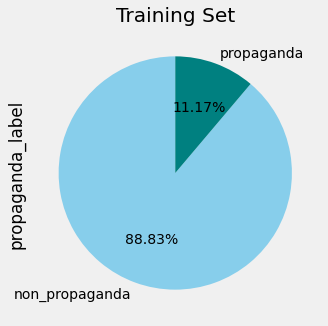

In [11]:
## checking for output labels
data = train_df['propaganda_label'].map({-1 : 'non_propaganda',
                                         1 : 'propaganda'}).value_counts()
pie_plot(data, 'Training Set')

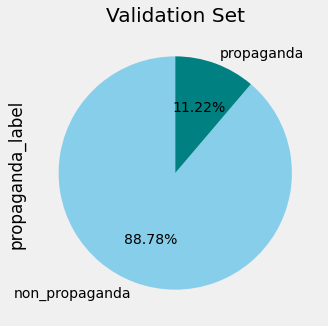

In [12]:
## checking for output labels
data = valid_df['propaganda_label'].map({-1 : 'non_propaganda',
                                         1 : 'propaganda'}).value_counts()
pie_plot(data, 'Validation Set')

**6. Text Preprocessing For Machine Learning Modelling**

In [13]:
## check for samples
train_df['text'].values[100]

'Prosecutors filed felony charges on Wednesday against an immigrant illegally living in the U.S. who is suspected in a drunken-driving crash that killed Indianapolis Colts linebacker Edwin Jackson and an Uber driver.  Manuel Orrego-Savala, who is from Guatemala and has twice been deported from the U.S., is charged with causing death while driving intoxicated and leaving the scene of an accident. The 37-year-old said little during his initial court hearing, responding through an interpreter as the judge explained the proceedings and charges.  "He\'s very distraught to say the least," said his lawyer, Jorge Torres. "He\'s very confused."  Investigators said Orrego-Savala was driving the pickup truck that hit Jackson and his Uber driver, 54-year-old Jeffrey Monroe, while the men were standing outside Monroe\'s car early Sunday along Interstate 70. Court documents allege a blood test conducted at a hospital determined Orrego-Savala had a blood-alcohol level of 0.19 percent, more than doubl

*6.1 Lowercasing Text*

In [14]:
## lowercase and check the sample
train_df['text_preprocessed'] = train_df['text'].str.lower()

train_df['text_preprocessed'].values[100]

'prosecutors filed felony charges on wednesday against an immigrant illegally living in the u.s. who is suspected in a drunken-driving crash that killed indianapolis colts linebacker edwin jackson and an uber driver.  manuel orrego-savala, who is from guatemala and has twice been deported from the u.s., is charged with causing death while driving intoxicated and leaving the scene of an accident. the 37-year-old said little during his initial court hearing, responding through an interpreter as the judge explained the proceedings and charges.  "he\'s very distraught to say the least," said his lawyer, jorge torres. "he\'s very confused."  investigators said orrego-savala was driving the pickup truck that hit jackson and his uber driver, 54-year-old jeffrey monroe, while the men were standing outside monroe\'s car early sunday along interstate 70. court documents allege a blood test conducted at a hospital determined orrego-savala had a blood-alcohol level of 0.19 percent, more than doubl

*6.2 Decontraction of english words*

In [15]:
## decontracting words
train_df['text_preprocessed'] = train_df['text_preprocessed'].str.replace(r"won\'t", "will not")\
                                                            .str.replace(r"can\'t", "can not")\
                                                            .str.replace(r"n\'t", " not")\
                                                            .str.replace(r"\'re", " are")\
                                                            .str.replace("\’s", " is")\
                                                            .str.replace(r"\'d", " would")\
                                                            .str.replace(r"\'ll", " will")\
                                                            .str.replace(r"\'t", " not")\
                                                            .str.replace(r"\'ve", " have")\
                                                            .str.replace(r"\'m", " am")\
                                                            .str.replace("\'s", " is")

train_df['text_preprocessed'].values[100]

'prosecutors filed felony charges on wednesday against an immigrant illegally living in the u.s. who is suspected in a drunken-driving crash that killed indianapolis colts linebacker edwin jackson and an uber driver.  manuel orrego-savala, who is from guatemala and has twice been deported from the u.s., is charged with causing death while driving intoxicated and leaving the scene of an accident. the 37-year-old said little during his initial court hearing, responding through an interpreter as the judge explained the proceedings and charges.  "he is very distraught to say the least," said his lawyer, jorge torres. "he is very confused."  investigators said orrego-savala was driving the pickup truck that hit jackson and his uber driver, 54-year-old jeffrey monroe, while the men were standing outside monroe is car early sunday along interstate 70. court documents allege a blood test conducted at a hospital determined orrego-savala had a blood-alcohol level of 0.19 percent, more than doubl

*6.3 Removal of Special Characters and Punctuations*

In [16]:
## removal of all special characters and punctuation
train_df['text_preprocessed'] = train_df['text_preprocessed'].str.replace(r'-', ' ')\
                                                             .str.replace(r'[^\w\s]', '')

train_df['text_preprocessed'].values[100]

'prosecutors filed felony charges on wednesday against an immigrant illegally living in the us who is suspected in a drunken driving crash that killed indianapolis colts linebacker edwin jackson and an uber driver  manuel orrego savala who is from guatemala and has twice been deported from the us is charged with causing death while driving intoxicated and leaving the scene of an accident the 37 year old said little during his initial court hearing responding through an interpreter as the judge explained the proceedings and charges  he is very distraught to say the least said his lawyer jorge torres he is very confused  investigators said orrego savala was driving the pickup truck that hit jackson and his uber driver 54 year old jeffrey monroe while the men were standing outside monroe is car early sunday along interstate 70 court documents allege a blood test conducted at a hospital determined orrego savala had a blood alcohol level of 019 percent more than double indiana is legal limi

*6.4 Remove Numbers and Digit*

In [17]:
## remove all numbers and digits present if any
train_df['text_preprocessed'] = train_df['text_preprocessed'].apply(lambda x :
                                                                    ' '.join([i for i in x.split()
                                                                     if not i.isdigit()]))

train_df['text_preprocessed'].values[100]

'prosecutors filed felony charges on wednesday against an immigrant illegally living in the us who is suspected in a drunken driving crash that killed indianapolis colts linebacker edwin jackson and an uber driver manuel orrego savala who is from guatemala and has twice been deported from the us is charged with causing death while driving intoxicated and leaving the scene of an accident the year old said little during his initial court hearing responding through an interpreter as the judge explained the proceedings and charges he is very distraught to say the least said his lawyer jorge torres he is very confused investigators said orrego savala was driving the pickup truck that hit jackson and his uber driver year old jeffrey monroe while the men were standing outside monroe is car early sunday along interstate court documents allege a blood test conducted at a hospital determined orrego savala had a blood alcohol level of percent more than double indiana is legal limit for driving th

*6.5 Removal of Stopwords*

In [18]:
## the below code is taken from the given source
## i am using a manually uploaded text file of stopwords to remove
## form the dataset
## https://gist.github.com/sebleier/554280
content = requests.get(STOPWORD_LIST_PATH).content
stopword_list = set(content.decode().splitlines())

In [19]:
## remove all possible stopwords to reduce the word count present in the dataset
## and make it more relevant
train_df["text_preprocessed"] = train_df["text_preprocessed"].apply(lambda x :
                                                                    ' '.join(e for e in x.split()
                                                                     if e not in stopword_list))

train_df['text_preprocessed'].values[100]

'prosecutors filed felony charges wednesday immigrant illegally living suspected drunken driving crash killed indianapolis colts linebacker edwin jackson uber driver manuel orrego savala guatemala deported charged causing death driving intoxicated leaving scene accident year initial court hearing responding interpreter judge explained proceedings charges distraught lawyer jorge torres confused investigators orrego savala driving pickup truck hit jackson uber driver year jeffrey monroe men standing monroe car early sunday interstate court documents allege blood test conducted hospital determined orrego savala blood alcohol level percent double indiana legal limit driving charges carry maximum sentence years prison orrego savala deported living illegally time crash investigators charged late tuesday federal prosecutors illegal entry deported alien faces years prison charge attorney office handled state charges resolved president donald trump drew attention case twitter calling highway co

*6.6 Lemmatization*

In [20]:
## applying lemmatization
stemmer = SnowballStemmer(language = 'english')

train_df["text_preprocessed"] = train_df["text_preprocessed"].apply(lambda x :
                                                                    " ".join(stemmer.stem(word)
                                                                    for word in x.split()))

train_df['text_preprocessed'].values[100]

'prosecutor file feloni charg wednesday immigr illeg live suspect drunken drive crash kill indianapoli colt lineback edwin jackson uber driver manuel orrego savala guatemala deport charg caus death drive intox leav scene accid year initi court hear respond interpret judg explain proceed charg distraught lawyer jorg torr confus investig orrego savala drive pickup truck hit jackson uber driver year jeffrey monro men stand monro car earli sunday interst court document alleg blood test conduct hospit determin orrego savala blood alcohol level percent doubl indiana legal limit drive charg carri maximum sentenc year prison orrego savala deport live illeg time crash investig charg late tuesday feder prosecutor illeg entri deport alien face year prison charg attorney offic handl state charg resolv presid donald trump drew attent case twitter call highway collis kill jackson monro disgrac presid prod democrat work illeg immigr border secur marion counti prosecutor terri curri critic comment off

*6.7 Final Function to For Text Preprocessing*

In [21]:
def final_preprocessing(data, stopword_list, stem_object):
    """This function will do final preprocessing on the given texts.
    """
    preprocessed_text_list = []

    for sentence in tqdm(data.values):

        sentence = sentence.lower()
        
        sentence = sentence.replace(r"won\'t", "will not").replace(r"can\'t", "can not")\
                           .replace(r"n\'t", " not").replace(r"\'re", " are")\
                           .replace("\’s", " is").replace(r"\'d", " would")\
                           .replace(r"\'ll", " will").replace(r"\'t", " not")\
                           .replace(r"\'ve", " have").replace(r"\'m", " am")\
                           .replace("\'s", " is")

        sentence = sentence.replace('-', ' ').replace('[^\w\s]', '')

        sentence = ' '.join([i for i in sentence.split() if not i.isdigit()])

        sentence = ' '.join(e for e in sentence.split() if e not in stopword_list)

        sentence = " ".join(stem_object.stem(word) for word in sentence.split())

        preprocessed_text_list.append(sentence)

    return preprocessed_text_list

In [22]:
## get validation preprocessed output and map to original dataset
valid_preprocessed_list = final_preprocessing(valid_df["text"], stopword_list, stemmer)
valid_df['text_preprocessed'] = valid_preprocessed_list

## get test preprocessed output and map to original dataset
test_preprocessed_list = final_preprocessing(test_df["text"], stopword_list, stemmer)
test_df['text_preprocessed'] = test_preprocessed_list

  0%|          | 0/5125 [00:00<?, ?it/s]

  0%|          | 0/10159 [00:00<?, ?it/s]

**7. Word Cloud Analysis**

In [23]:
def word_cloud_plot(text_list, stopword_list):
    """This function creates the word cloud by taking
       all words into consideration.
    """
    ## get all words
    all_present_words = ' '.join(word for line in text_list 
                                 for word in line.split())

    ## word cloud plotting
    word_cloud_list = WordCloud(width = 600, height = 600, 
                                stopwords = set(stopword_list),
                                min_font_size = 15,
                                background_color = "black")\
                                .generate(all_present_words)
    #display image
    plt.figure(figsize=(15,10))
    plt.imshow(word_cloud_list, interpolation='bilinear')
    plt.axis("off")
    plt.show()

*7.1 check for non-propaganda words*

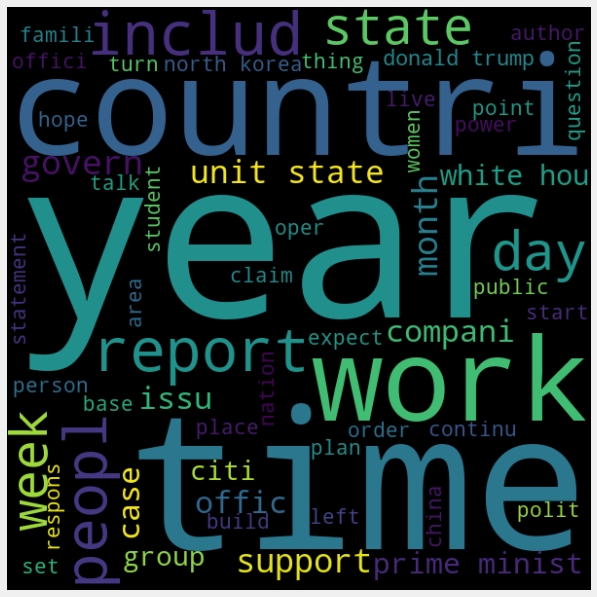

In [24]:
word_cloud_plot(train_df[train_df['propaganda_label'] == -1]["text_preprocessed"],
                stopword_list)

*7.2 check for propaganda words*

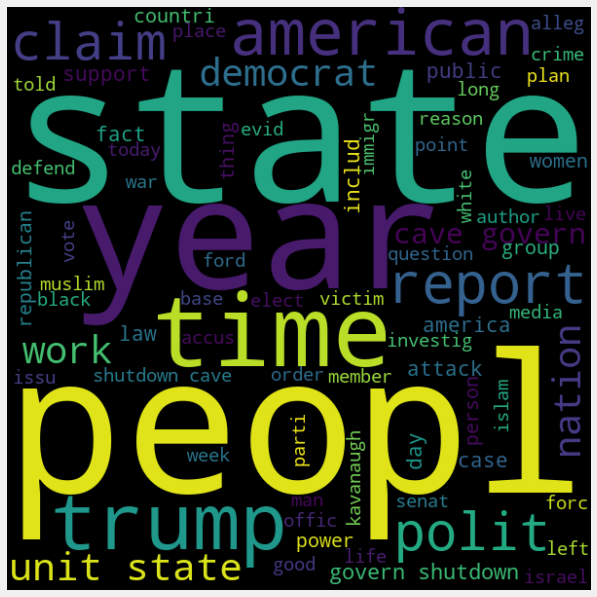

In [25]:
word_cloud_plot(valid_df[valid_df['propaganda_label'] == 1]["text_preprocessed"],
                stopword_list)

**8. N-Gram Analysis**

In [26]:
#Source: - https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc
"""function to generate ngrams and plot the data"""
def generate_ngrams(text, n_gram):
    #generating token
    word = [token for token in str(text).lower().split(" ") if token != ""]
    #generating ngrams
    ngrams = zip(*[word[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]



def freq_ngrams(text, n_gram, range, title):
    """parameters : text, number of ngrams(1,2,3), range(top ngrams)
       return : plot of word vs no of occurance
    """
    freq_dict = defaultdict(int)
    for sent in text:
        for w in generate_ngrams(sent,n_gram):
            freq_dict[w] += 1
    freq_dict = dict(freq_dict)
    #sorting dict to descending order
    qstn_txt = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
    qstn_txt.columns = ["word", "wordcount"]
    fig = plt.figure(figsize = (20,5))
    plt.bar(qstn_txt.word[0:range], qstn_txt.wordcount[0:range])
    plt.xticks(rotation = 90)
    plt.xlabel("words", fontsize=15)
    plt.xlabel("count", fontsize=15)
    plt.title(title, fontsize=20)
    return plt.show()

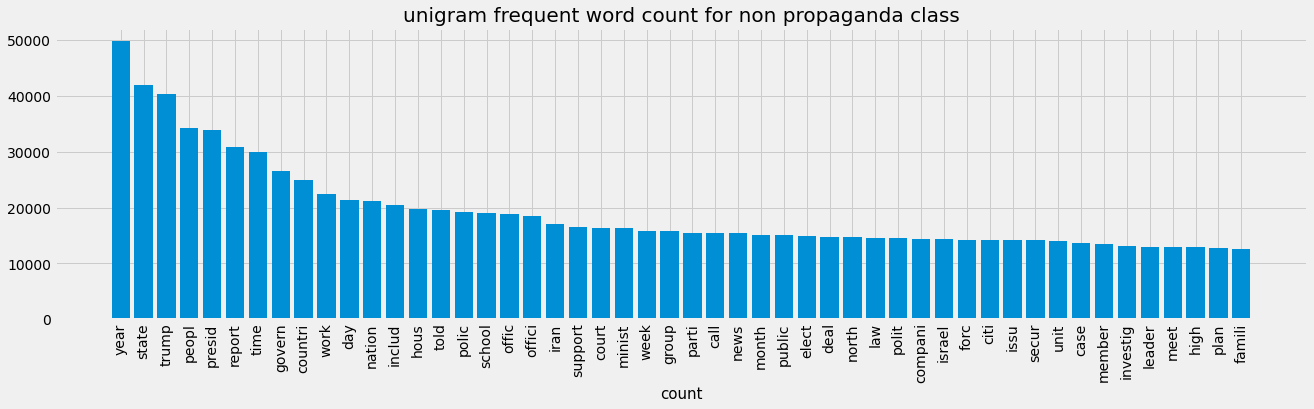

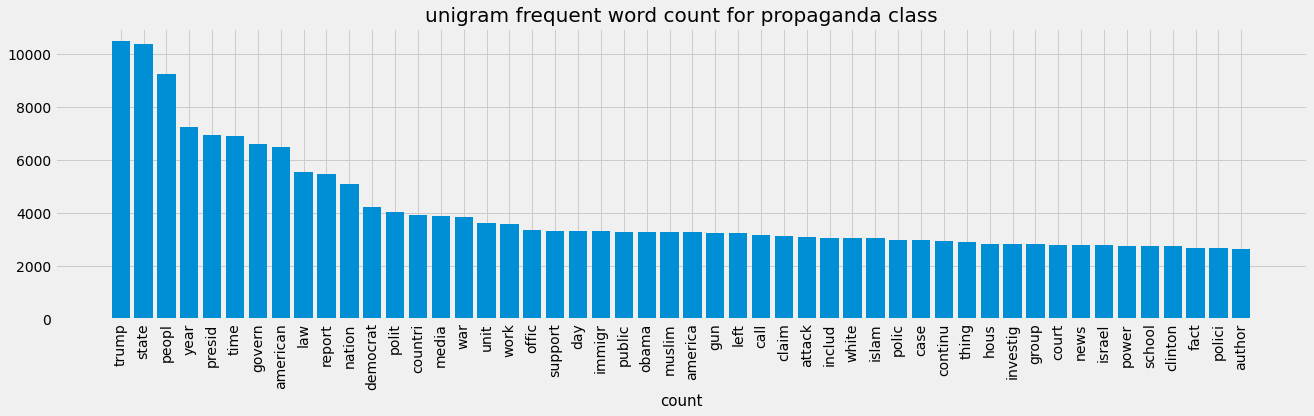

In [27]:
freq_ngrams(train_df[train_df['propaganda_label'] == -1]["text_preprocessed"],
            n_gram=1, range=50, 
            title="unigram frequent word count for non propaganda class")
freq_ngrams(train_df[train_df['propaganda_label'] == 1]["text_preprocessed"],
            n_gram=1, range=50, 
            title="unigram frequent word count for propaganda class")

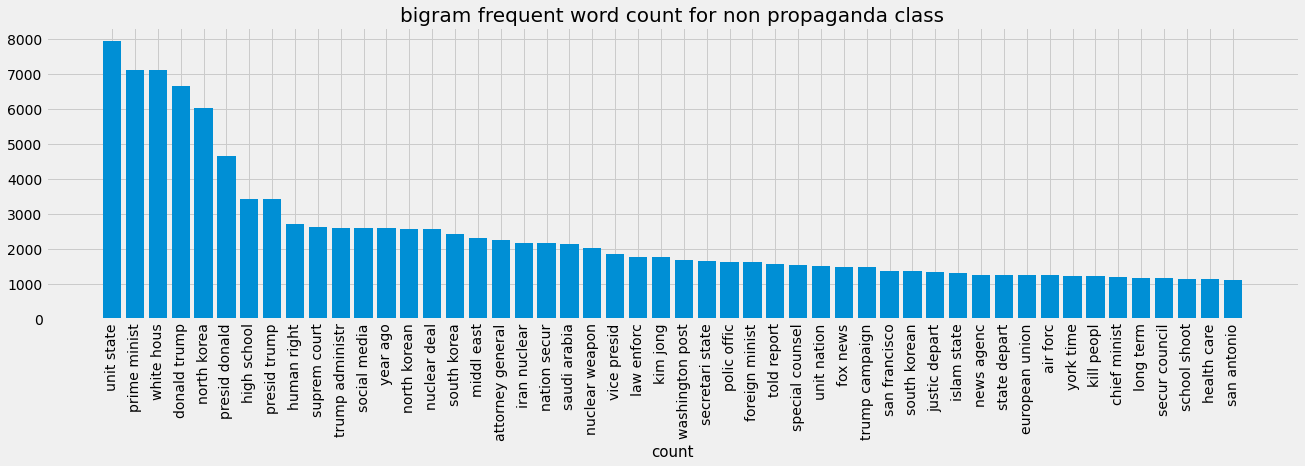

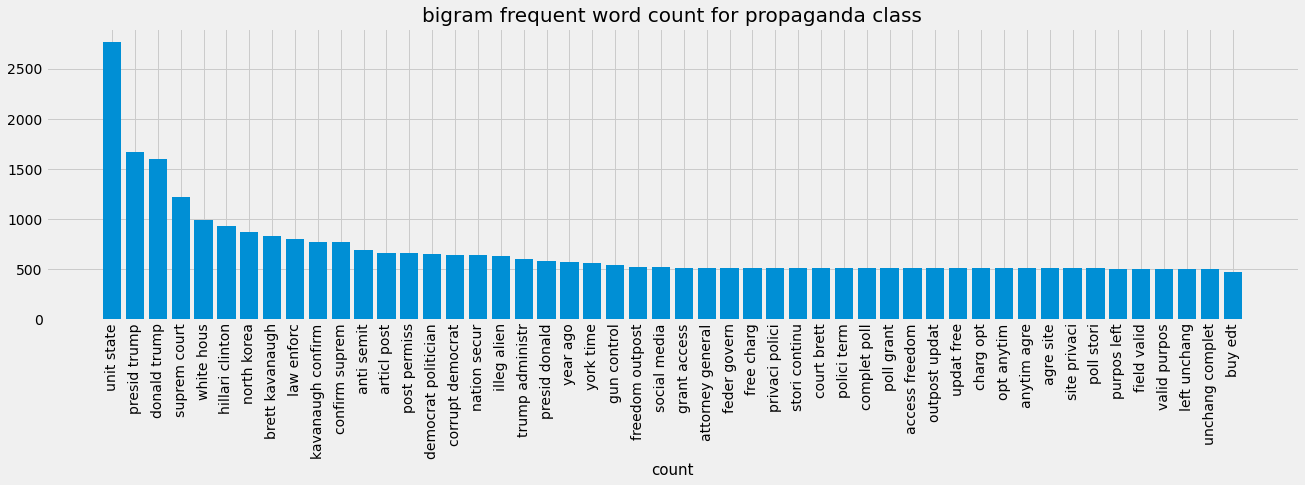

In [28]:
freq_ngrams(train_df[train_df['propaganda_label'] == -1]["text_preprocessed"],
            n_gram=2, range=50, 
            title="bigram frequent word count for non propaganda class")
freq_ngrams(train_df[train_df['propaganda_label'] == 1]["text_preprocessed"],
            n_gram=2, range=50, 
            title="bigram frequent word count for propaganda class")

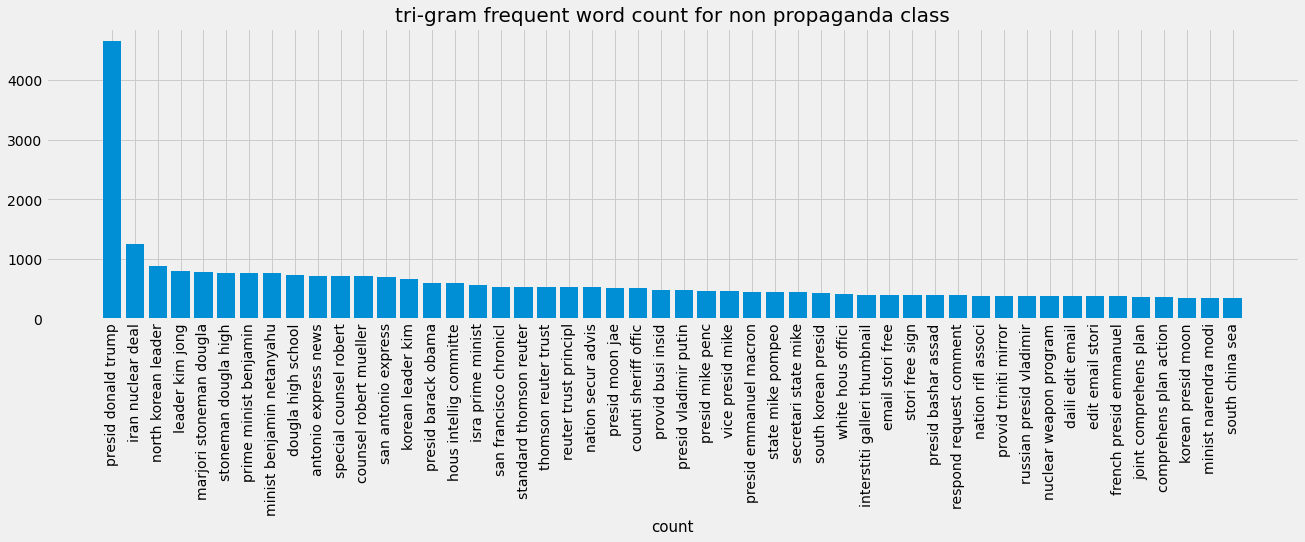

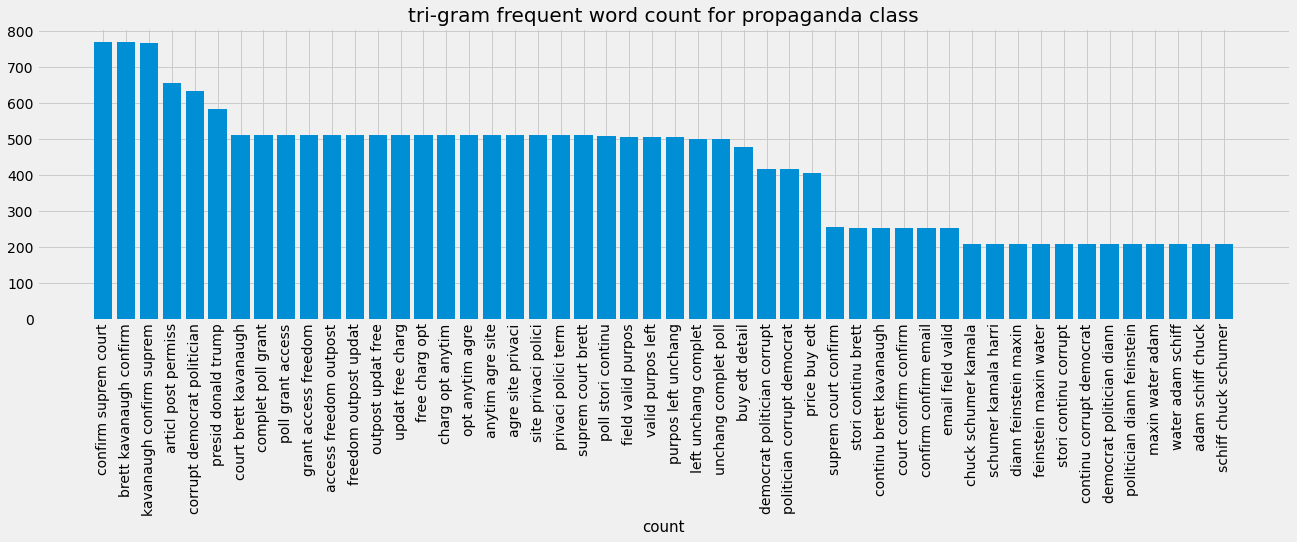

In [29]:
freq_ngrams(train_df[train_df['propaganda_label'] == -1]["text_preprocessed"],
            n_gram=3, range=50, 
            title="tri-gram frequent word count for non propaganda class")
freq_ngrams(train_df[train_df['propaganda_label'] == 1]["text_preprocessed"],
            n_gram=3, range=50, 
            title="tri-gram frequent word count for propaganda class")

**9. Dumped the Preprocessed Data**

In [30]:
train_df.to_csv(os.path.join(FOLDER_PATH, 'preprocessed_train.csv'), index=False)
valid_df.to_csv(os.path.join(FOLDER_PATH, 'preprocessed_valid.csv'), index=False)
test_df.to_csv(os.path.join(FOLDER_PATH, 'preprocessed_test.csv'), index=False)